# Machine Learning Diagnostic

In [1]:
import pandas as pd
import urllib
import re
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from pandas.io.json import json_normalize
import json
import requests
from datetime import datetime

In [ ]:
def soda_loop(url):
    '''
    This function takes an api key of a version of the identified 311 service call dataset saved in socrata
    and loops through the dataset until all the data is retrieved
    
    Input:
        url - chicago data portal api endpoint
    Output:
        pandas database
    '''
    offset_num = 0
    df = pd.DataFrame()
    count = 0
    use_url = url
    while len(pd.read_json(use_url)):

        df = pd.concat([df,pd.read_json(use_url)])
        
        use_url = url
  
        offset_num+=50000
   
        use_url=url+'&$offset={}'.format(offset_num)
                
        count+=1
        
        print(use_url)
        
    return df

In [2]:
cd Documents/capp30254/hws

/Users/andrewyaspan/Documents/capp30254/hws


In [4]:

#query 311 graffiti data
raw_graffiti = soda_loop('https://data.cityofchicago.org/resource/qr2f-jf4g.json?$limit=50000')

#query 311 vacant lot and abandon buildings reported
raw_vac = soda_loop('https://data.cityofchicago.org/resource/4mhb-6abn.json?$limit=50000')


#query 311 potholes reported
raw_ph = soda_loop('https://data.cityofchicago.org/resource/ej8m-yavt.json?$limit=50000')

#query 311 sanitation code complaints
raw_san = soda_loop('https://data.cityofchicago.org/resource/tybt-vtit.json?$limit=50000')


https://data.cityofchicago.org/resource/qr2f-jf4g.json?$limit=50000&$offset=50000
https://data.cityofchicago.org/resource/qr2f-jf4g.json?$limit=50000&$offset=100000
https://data.cityofchicago.org/resource/qr2f-jf4g.json?$limit=50000&$offset=150000
https://data.cityofchicago.org/resource/4mhb-6abn.json?$limit=50000&$offset=50000
https://data.cityofchicago.org/resource/ej8m-yavt.json?$limit=50000&$offset=50000
https://data.cityofchicago.org/resource/ej8m-yavt.json?$limit=50000&$offset=100000
https://data.cityofchicago.org/resource/tybt-vtit.json?$limit=50000&$offset=50000


In [252]:
raw_ph = pd.read_csv('potholes_last_year.csv')

raw_vac = pd.read_csv('vacant_last_year.csv')

raw_san = pd.read_csv('sanitation_last_year.csv')

raw_graffiti = pd.read_csv('graffiti_last_year.csv')

In [3]:
pd.set_option("display.max_columns",80)
pd.set_option("display.max_rows",305)

In [462]:
raw_vac['street_address'] = raw_vac[raw_vac.columns[[0,1,2,3]]].apply(lambda x: ' '.join(x.astype(str).astype(str)),axis=1)

In [463]:
raw_vac = raw_vac.drop(raw_vac.columns[[0,1,2,3]],1)

In [ ]:
#pd.merge(raw_graffiti, raw_vac, raw_ph, raw_san, how='inner', on=['latitude','longitude'],
#         left_index=False, right_index=False, sort=True, copy=True, indicator=False)

raw_vac_e = raw_vac.rename(index=str, columns={'date_service_request_was_received':'creation_date','service_request_type':'type_of_service_request'})
#raw_vac_e = raw_vac.rename(index=str, columns={'service_request_type':'type_of_service_request'})
dfs = [raw_graffiti, raw_vac_e, raw_ph, raw_san]
raw_311 = pd.concat(dfs)
raw_311_sub = raw_311[['creation_date','completion_date','community_area','street_address','type_of_service_request', 'latitude', 'longitude','police_district','ward','is_building_open_or_boarded_','number_of_potholes_filled_on_block','what_type_of_surface_is_the_graffiti_on_','what_is_the_nature_of_this_code_violation_','x_coordinate','y_coordinate','zip']].copy()


In [13]:
raw_311_sub.to_csv('chicago_combined.csv',sep=',')

In [4]:
raw_311_sub = pd.read_csv('chicago_combined.csv')
raw_311_sub = raw_311_sub.drop('Unnamed: 0', axis=1)

/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
def sub_san(df):
    is_san = df['type_of_service_request'] == "Sanitation Code Violation"
    sanitation = df[is_san]
    return sanitation

def sub_vac(df):
    is_vac = df['type_of_service_request'] == "Vacant/Abandoned Building"
    vacant = df[is_vac]
    return vacant

def sub_ph(df):
    is_ph = df['type_of_service_request'] == "Pothole in Street"
    potholes = df[is_ph]
    return potholes

def sub_graf(df):
    is_graf = df['type_of_service_request'] == "Graffiti Removal"
    graffiti = df[is_graf]
    return graffiti


# Tables and Graphs by type of Service Request

In [259]:
pd.DataFrame(raw_311_sub['type_of_service_request'].value_counts())

,type_of_service_request
Graffiti Removal,116894
Pothole in Street,55801
Sanitation Code Violation,21453
Vacant/Abandoned Building,4718


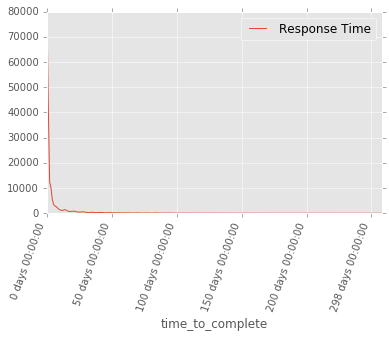

In [282]:

raw_311_sub['time_to_complete'] = pd.to_datetime(raw_311_sub['completion_date'])-pd.to_datetime(raw_311_sub['creation_date'])
raw_311_sub.groupby('time_to_complete').size().to_frame().rename(columns={0:'Response Time'}).plot(rot=70)
plt.show()


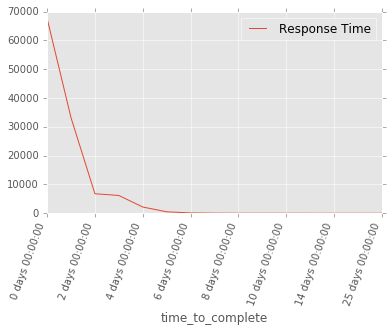

In [290]:
graffiti = sub_graf(raw_311_sub)
graffiti.groupby('time_to_complete').size().to_frame().rename(columns={0:'Response Time'}).plot(rot=70)
plt.show()

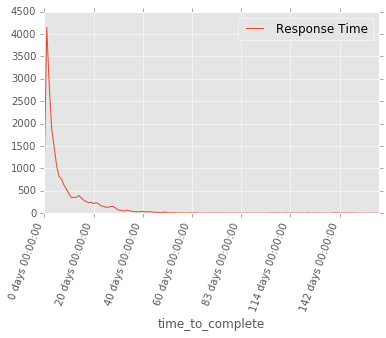

In [292]:
sanitation = sub_san(raw_311_sub)
sanitation.groupby('time_to_complete').size().to_frame().rename(columns={0:'Response Time'}).plot(rot=70)
plt.show()

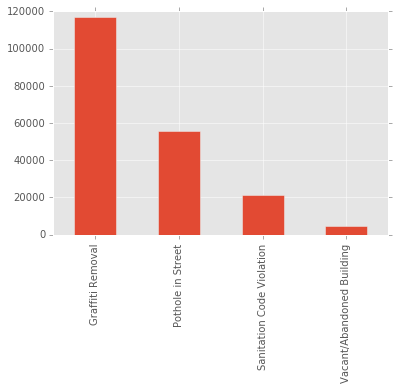

In [158]:
raw_311_sub['type_of_service_request'].value_counts().plot("bar")
plt.figure()
plt.show()

<h3><b>Interesting discovery number 1</b>: The top request is <b>graffiti removal</b> by almost <i><b>50,000 requests</b></i><h3>

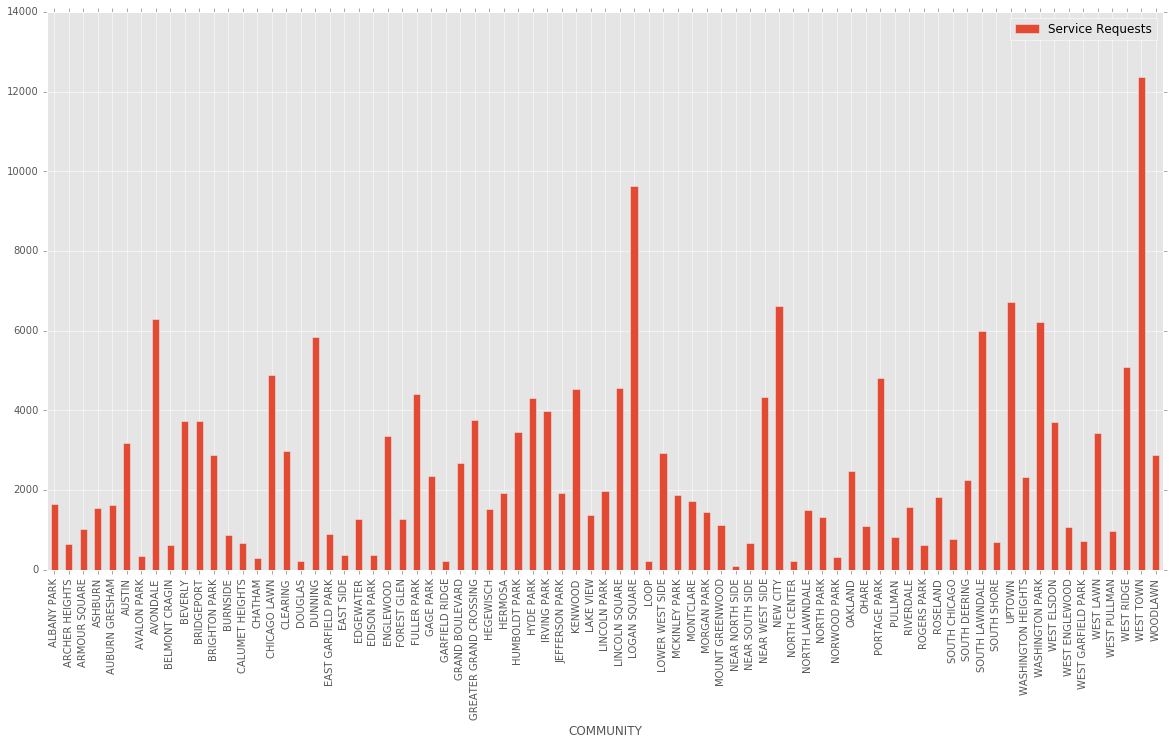

In [430]:
raw_311_sub.groupby('COMMUNITY').size().to_frame().rename(columns={0:'Service Requests'}).plot(kind='bar', fontsize=10,rot=90, figsize =(20,10))
plt.figure()
plt.show()

In [427]:
areas = pd.read_csv('CommAreas.csv')
areas.rename(columns = {'AREA_NUMBE': 'community area'})
raw_311_sub['community area'] = raw_311_sub.community_area.dropna().astype(int)
raw_311_sub = raw_311_sub.join(areas, on= 'community area')
raw_311_sub.groupby('COMMUNITY').size().to_frame().transpose()

COMMUNITY,ALBANY PARK,ARCHER HEIGHTS,ARMOUR SQUARE,ASHBURN,AUBURN GRESHAM,AUSTIN,AVALON PARK,AVONDALE,BELMONT CRAGIN,BEVERLY,BRIDGEPORT,BRIGHTON PARK,BURNSIDE,CALUMET HEIGHTS,CHATHAM,CHICAGO LAWN,CLEARING,DOUGLAS,DUNNING,EAST GARFIELD PARK,EAST SIDE,EDGEWATER,EDISON PARK,ENGLEWOOD,FOREST GLEN,FULLER PARK,GAGE PARK,GARFIELD RIDGE,GRAND BOULEVARD,GREATER GRAND CROSSING,HEGEWISCH,HERMOSA,HUMBOLDT PARK,HYDE PARK,IRVING PARK,JEFFERSON PARK,KENWOOD,LAKE VIEW,LINCOLN PARK,LINCOLN SQUARE,LOGAN SQUARE,LOOP,LOWER WEST SIDE,MCKINLEY PARK,MONTCLARE,MORGAN PARK,MOUNT GREENWOOD,NEAR NORTH SIDE,NEAR SOUTH SIDE,NEAR WEST SIDE,NEW CITY,NORTH CENTER,NORTH LAWNDALE,NORTH PARK,NORWOOD PARK,OAKLAND,OHARE,PORTAGE PARK,PULLMAN,RIVERDALE,ROGERS PARK,ROSELAND,SOUTH CHICAGO,SOUTH DEERING,SOUTH LAWNDALE,SOUTH SHORE,UPTOWN,WASHINGTON HEIGHTS,WASHINGTON PARK,WEST ELSDON,WEST ENGLEWOOD,WEST GARFIELD PARK,WEST LAWN,WEST PULLMAN,WEST RIDGE,WEST TOWN,WOODLAWN
0,1642,639,1019,1542,1626,3187,334,6293,614,3734,3733,2881,866,664,308,4884,2973,221,5834,898,381,1263,366,3364,1280,4408,2350,216,2683,3765,1525,1920,3446,4298,3972,1935,4548,1375,1982,4558,9622,209,2920,1882,1733,1449,1112,105,664,4346,6616,227,1512,1325,323,2467,1092,4822,817,1579,634,1817,778,2257,5987,692,6729,2322,6219,3708,1074,715,3436,977,5092,12366,2872


<h3><b>Interesting discovery number 2</b>: <b>West Town</b> has the <b>most service requests</b> with <i><b>12366</b></i></h3>

<h3><b>Interesting discovery number 3</b>: <b>Near North Side</b> has the <b>fewest</b> with only 105 <i><b>requests</b></i></h3>


In [435]:
by_area = raw_311_sub.groupby(['COMMUNITY', 'type_of_service_request']).size().to_frame()
by_area

0
COMMUNITY              type_of_service_request        
ALBANY PARK            Graffiti Removal            954
                       Pothole in Street           516
                       Sanitation Code Violation   169
                       Vacant/Abandoned Building     3
ARCHER HEIGHTS         Graffiti Removal            167
                       Pothole in Street           368
                       Sanitation Code Violation    78
                       Vacant/Abandoned Building    26
ARMOUR SQUARE          Graffiti Removal            688
                       Pothole in Street           250
                       Sanitation Code Violation    79
                       Vacant/Abandoned Building     2
ASHBURN                Graffiti Removal            160
                       Pothole in Street           541
                       Sanitation Code Violation   504
                       Vacant/Abandoned Building   337
AUBURN GRESHAM         Graffiti Removal             67
                       Pothole in Street           826
                       Sanitation Code Violation   490
                       Vacant/Abandoned Building   243
AUSTIN                 Graffiti Removal            790
                       Pothole in Street          1435
                       Sanitation Code Violation   808
                       Vacant/Abandoned Building   154
AVALON PARK            Graffiti Removal             50
                       Pothole in Street           161
                       Sanitation Code Violation    84
                       Vacant/Abandoned Building    39
AVONDALE               Graffiti Removal           5357
                       Pothole in Street           639
                       Sanitation Code Violation   277
                       Vacant/Abandoned Building    20
BELMONT CRAGIN         Graffiti Removal            282
                       Pothole in Street           296
                       Sanitation Code Violation    34
                       Vacant/Abandoned Building     2
BEVERLY                Graffiti Removal           1942
                       Pothole in Street          1375
                       Sanitation Code Violation   351
                       Vacant/Abandoned Building    66
BRIDGEPORT             Graffiti Removal           2686
                       Pothole in Street           470
                       Sanitation Code Violation   568
                       Vacant/Abandoned Building     9
BRIGHTON PARK          Graffiti Removal           1217
                       Pothole in Street          1280
                       Sanitation Code Violation   350
                       Vacant/Abandoned Building    34
BURNSIDE               Graffiti Removal             87
                       Pothole in Street           351
                       Sanitation Code Violation   304
                       Vacant/Abandoned Building   124
CALUMET HEIGHTS        Graffiti Removal             37
                       Pothole in Street           452
                       Sanitation Code Violation   115
                       Vacant/Abandoned Building    60
CHATHAM                Graffiti Removal             41
                       Pothole in Street           187
                       Sanitation Code Violation    66
                       Vacant/Abandoned Building    14
CHICAGO LAWN           Graffiti Removal           4126
                       Pothole in Street           461
                       Sanitation Code Violation   250
                       Vacant/Abandoned Building    47
CLEARING               Graffiti Removal           1781
                       Pothole in Street           579
                       Sanitation Code Violation   381
                       Vacant/Abandoned Building   232
DOUGLAS                Graffiti Removal             79
                       Pothole in Street           141
                       Vacant/Abandoned Building     1
DUNNING                Graffiti Remova

In [ ]:
raw_311_sub.rename(columns={0:'Graffiti Removal'}).plot(kind='bar', fontsize=10,rot=90, figsize =(20,10))

# Tables and Graphs by Subtype 

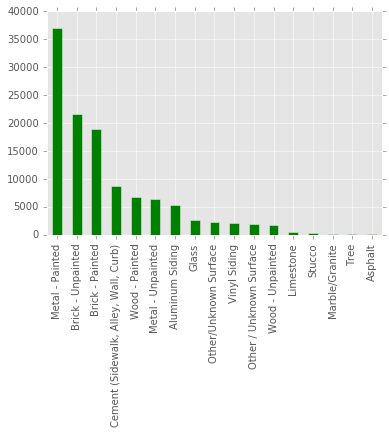

In [341]:
raw_graffiti['What Type of Surface is the Graffiti on?'].value_counts().plot('bar', color = 'g')
plt.figure()
plt.show()

<h2>Interesting Discovery 5: The most "graffitied" surface is painted metal. <h2>

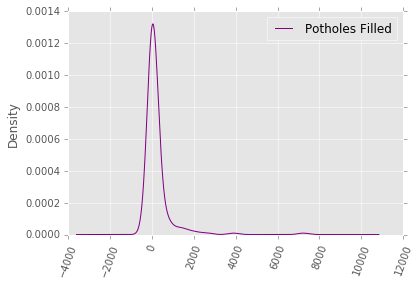

In [337]:
raw_ph.groupby('NUMBER OF POTHOLES FILLED ON BLOCK').size().to_frame().rename(columns={0:'Potholes Filled'}).plot.density(rot=70, color = 'purple')
plt.show()


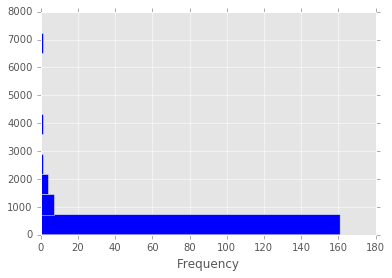

In [334]:
raw_ph['NUMBER OF POTHOLES FILLED ON BLOCK'].value_counts().plot.hist(orientation='horizontal', color = 'b')
plt.figure()
plt.show()

 <h3>Interesting discovery 4: Pot hole fillings are concentrated around particluar areas</h3>

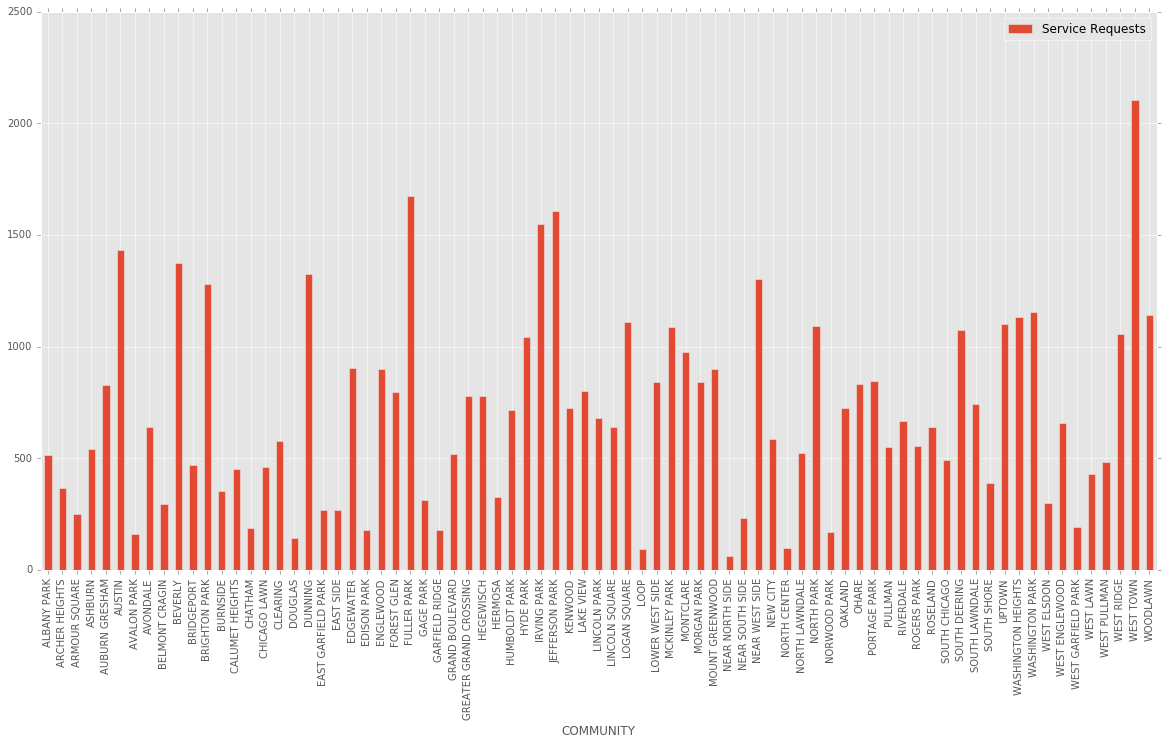

In [483]:
potholes = sub_ph(raw_311_sub)
potholes.groupby('COMMUNITY').size().to_frame().rename(columns={0:'Service Requests'}).plot(kind='bar', fontsize=10,rot=90, figsize =(20,10))
plt.figure()
plt.show()

<h3> They tend to be located in areas of Downtown, as well as areas east of West Town and north of Downtown, which according to Crain's (see http://www.chicagobusiness.com/article/20130108/BLOGS08/130109821/how-rich-is-your-neighborhood) are among the wealthiest areas of the city.<h3> 

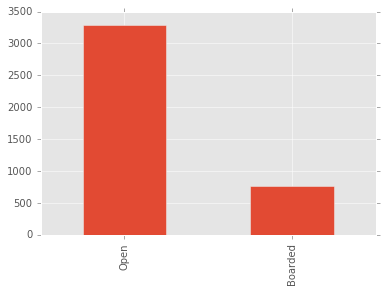

In [486]:
raw_vac['IS BUILDING OPEN OR BOARDED?'].value_counts().plot('bar')
plt.figure()
plt.show()

In [24]:

def find_fips(df):
    '''
    This function finds the fips number based on the latitude and longitude for the 311 request place of interest
    
    Input:
        Pandas dataframe of 311 service requests
    Output: 
        Dataframe that has an acs block and tract number added to the frame.
    '''
        
    acs_df = pd.DataFrame()

    for row in df.itertuples():
        
        lat = row[6]
        long = row[7]

        if str(lat) == 'nan':
            continue

        fcc_api_call = 'http://data.fcc.gov/api/block/find?format=json&latitude={}&longitude={}&showall=true'.format(lat,long)

        try:
            fcac = pd.read_json(fcc_api_call)
            fips = str(int(fcac['Block']['FIPS']))
        except ValueError:
            d = json.loads(requests.get(fcc_api_call).text)
            fips = pd.DataFrame(d['Block']['intersection'])['FIPS'][0]

        #block group digits
        block_group = fips[-4]

        #tract digits
        tract = fips[-10:-4]

        if fips == 'nan':
            continue

        df_addtract = pd.DataFrame(df.ix[row[0]]).transpose().reset_index().join(pd.DataFrame({'tract':tract, 'block group':block_group}, index=[0]))

        acs_df = pd.concat([acs_df, df_addtract])

    return acs_df

In [7]:
sort_sub_311 = raw_311_sub.sort('creation_date')

/Users/andrewyaspan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [9]:
sort_sub_311 = sort_sub_311.drop('Unnamed: 0', axis=1)

In [118]:
better_result = pd.read_json('chicago_combined_acs_correct.json')

In [164]:
better_result.transpose().head()

,block group,community_area,completion_date,creation_date,index,is_building_open_or_boarded_,latitude,longitude,number_of_potholes_filled_on_block,police_district,street_address,tract,type_of_service_request,ward,what_is_the_nature_of_this_code_violation_,what_type_of_surface_is_the_graffiti_on_,x_coordinate,y_coordinate,zip
0,1,65,2017-03-31T00:00:00,2017-03-31T00:00:00,0,None,41.7844,-87.7136,None,8,3606 W 60TH ST,837300,Graffiti Removal,23,None,Wood - Unpainted,1.15331e+06,1.86459e+06,None
1,4,30,2017-03-31T00:00:00,2017-03-31T00:00:00,24,None,41.8529,-87.7005,None,10,2922 W 21ST PL,031400,Graffiti Removal,24,None,Brick - Unpainted,1.15673e+06,1.88959e+06,None
10,1,28,2017-03-31T00:00:00,2017-03-31T00:00:00,44,None,41.8608,-87.6857,None,12,1511 S WESTERN AVE,740200,Graffiti Removal,28,None,Metal - Painted,1.16062e+06,1.89255e+06,None
100,3,59,None,2017-03-31T00:00:00,182,None,41.8341,-87.6754,None,9,2000 W 33RD ST,730600,Graffiti Removal,12,None,Brick - Unpainted,1.16356e+06,1.88279e+06,None
1000,1,30,2017-03-28T00:00:00,2017-03-27T00:00:00,1638,None,41.8517,-87.7013,None,10,3021 W CERMAK RD,561000,Graffiti Removal,12,None,Other / Unknown Surface,1.15649e+06,1.88923e+06,None


In [134]:
better_result_tp = better_result.transpose()

In [19]:
better_result = better_result.drop('Unnamed: 0', axis=1)

In [ ]:
best_result = find_fips(sort_sub_311.sample(n=1000))

In [190]:
best_result = best_result.reset_index(drop=True)

In [191]:
best_result.to_json('chicago_acs_sample.json', orient = 'index')

In [7]:
best_result = pd.read_json('chicago_acs_sample.json')

In [8]:
best_result = best_result.transpose()

In [19]:
best_result.head()

,block group,community_area,completion_date,creation_date,index,is_building_open_or_boarded_,latitude,longitude,number_of_potholes_filled_on_block,police_district,street_address,tract,type_of_service_request,ward,what_is_the_nature_of_this_code_violation_,what_type_of_surface_is_the_graffiti_on_,x_coordinate,y_coordinate,zip
0,3,24,2016-06-16T00:00:00,2016-06-16T00:00:00,89977,None,41.9104,-87.6754,None,14,1909 W NORTH AVE,241500,Graffiti Removal,2,None,Brick - Unpainted,1.16334e+06,1.91067e+06,None
1,2,7,2016-07-29T00:00:00,2016-07-27T00:00:00,155104,None,41.9129,-87.6473,None,18,1702 N BURLING ST,071800,Pothole in Street,2,None,None,1.17103e+06,1.91157e+06,60614
10,1,69,2017-01-18T00:00:00,2017-01-17T00:00:00,139298,None,41.7729,-87.6156,None,3,6700 S DR MARTIN LUTHER KING JR DR,690400,Pothole in Street,20,None,None,1.18007e+06,1.86068e+06,60637
100,2,55,2016-09-02T00:00:00,2016-08-24T00:00:00,152162,None,41.6547,-87.5538,4,4,13235 S BRAINARD AVE,550200,Pothole in Street,10,None,None,1.19729e+06,1.81766e+06,60633
101,3,63,2016-06-07T00:00:00,2016-06-04T00:00:00,94261,None,41.7964,-87.7032,None,9,3150 W 53RD PL,630400,Graffiti Removal,14,None,Aluminum Siding,1.15662e+06,1.86899e+06,None


In [11]:
fcac = pd.read_json('http://data.fcc.gov/api/block/find?format=json&latitude=41.78437373&longitude=-87.71364839&showall=true')

In [10]:
response = urllib.request.urlopen('http://api.census.gov/data/2015/acs5?get=NAME,B02008_001E,B02009_001E,B02011_001E&for=block+group:*&in=state:17&in=county:031&in=tract:*&key=d53148b74dc29b6d066fe5ecbf2f030e63183f04')
html=response.read()
df = pd.read_json(html, typ='frame')
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df = df.rename(columns = new_header) #set the header row as the df header

In [12]:
merged_chicago_rand_acs = pd.merge(best_result,df, on=['block group','tract'], how = "inner")  ##THIS ONE IS KEY

In [527]:
merged_chicago_acs = pd.merge(df, better_result_tp, on=['tract'], how = "inner")  ##THIS ONE IS KEY

In [528]:
merge_chicago_acs_name = merged_chicago_acs.rename(columns = {'B02008_001E':'white', 'B02009_001E':'black','B02011_001E':'asian'})

In [14]:
merge_chicago_rand = merged_chicago_rand_acs.rename(columns = {'B02008_001E':'white', 'B02009_001E':'black','B02011_001E':'asian'})

# Plots of Chicago with Select ACS Data

I took a random sample of 1000 requests and matched with the population of residents of white, black and asian demographics based on the acs 5 year survey data based on tract and block.

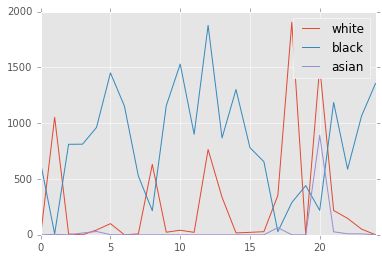

In [19]:
#is_vacant = merge_chicago_rand['type_of_service_request'] == "Vacant/Abandoned Building"
vacant = sub_vac(merge_chicago_rand)
plt.figure()
vacant[['white','black','asian']].astype(float).reset_index(drop=True).plot(kind='line')
plt.show()

<h3>It seems that areas with more Black and Asian American residents call 311 about Vacant and Abandoned buildings.</h3>

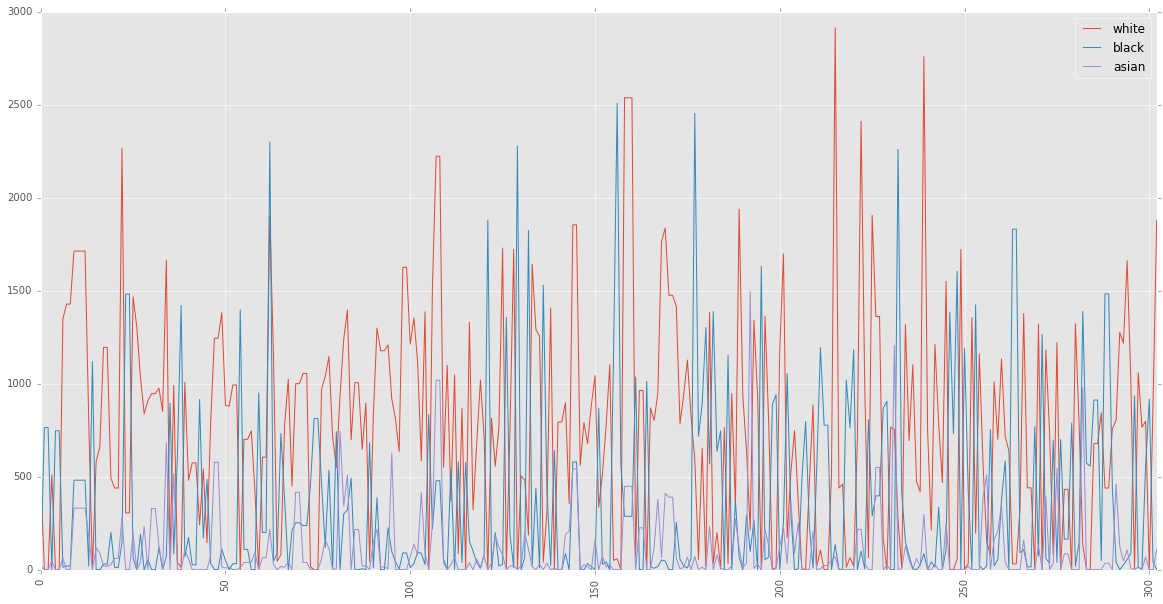

In [20]:
is_pot = merge_chicago_rand['type_of_service_request'] == "Pothole in Street"
pothole = merge_chicago_rand[is_pot]
plt.figure()
pothole[['white','black','asian']].astype(float).reset_index(drop=True).plot(kind='line',fontsize=10,rot=90, figsize =(20,10) )
plt.show()

<h3> It is hard to draw a trends about what type of neighborhood makes more calls about potholes, there is a wide variation amongst people of each ethnicity.  However, it seems that areas with more white people, in particular, are calling in more requests about potholes.<h3>

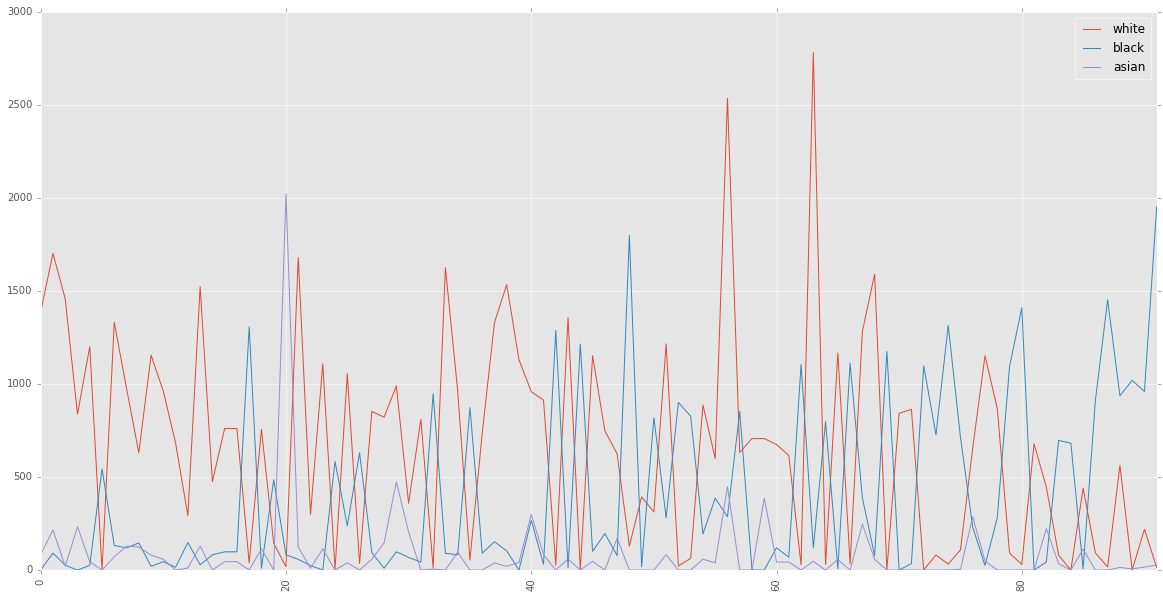

In [21]:
#is_san = merge_chicago_rand['type_of_service_request'] == "Sanitation Code Violation"
sanitation = sub_san(merge_chicago_rand)
plt.figure()
sanitation[['white','black','asian']].astype(float).reset_index(drop=True).plot(kind='line', fontsize=10,rot=90, figsize =(20,10))
plt.show()

<h3>It seems that areas with a slightly higher number of Black residents relative to White residents call 311 about sanitation code violations.</h3>

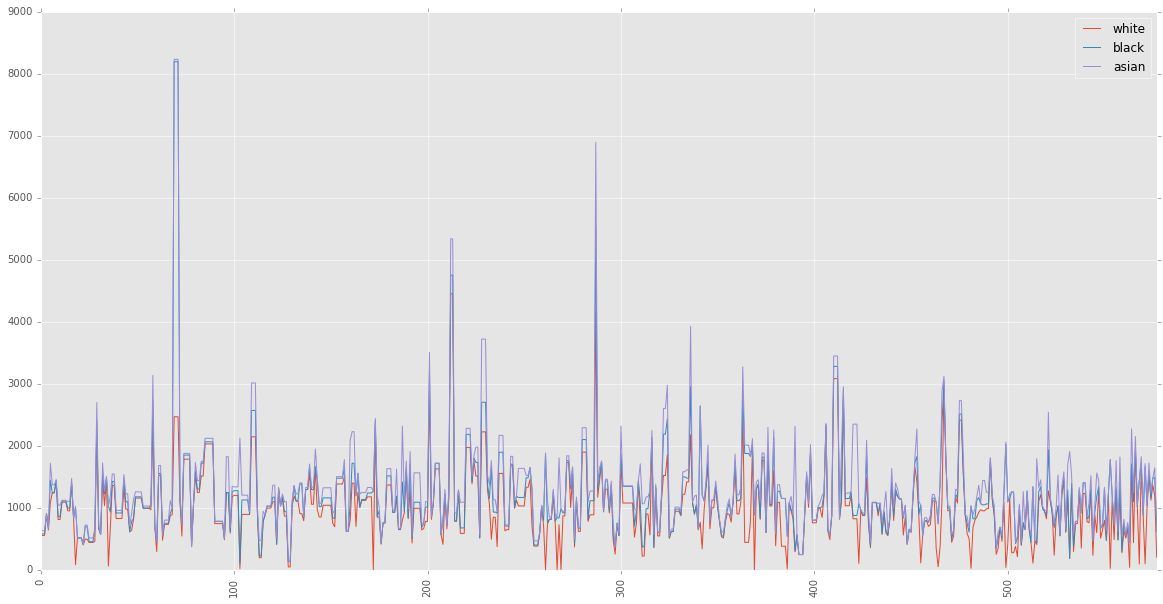

In [22]:
#is_graf = merge_chicago_rand['type_of_service_request'] == "Grafitti Removal"
graffiti = sub_graf(merge_chicago_rand)
plt.figure()
graffiti[['white','black','asian']].astype(float).reset_index(drop=True).plot(kind='line',stacked=True, fontsize=10,rot=90, figsize =(20,10))
plt.show()
plt.show()

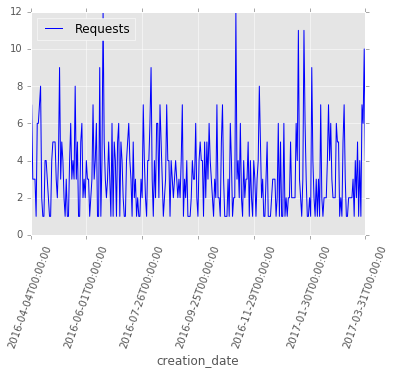

In [329]:
merge_chicago_rand.groupby('creation_date').size().to_frame().rename(columns={0:'Requests'}).plot(rot=70, color='b')
plt.show()

In [23]:
is_wolcott = raw_311_sub['street_address'] =='7500 S WOLCOTT AVE'
wolcott = raw_311_sub[is_wolcott]
wolcott


,creation_date,completion_date,community_area,street_address,type_of_service_request,latitude,longitude,police_district,ward,is_building_open_or_boarded_,number_of_potholes_filled_on_block,what_type_of_surface_is_the_graffiti_on_,what_is_the_nature_of_this_code_violation_,x_coordinate,y_coordinate,zip
170336,2016-05-02T00:00:00,2016-07-12T00:00:00,71.0,7500 S WOLCOTT AVE,Pothole in Street,41.757345,-87.671052,6.0,17.0,NaN,3.0,NaN,NaN,1.164988e+06,1.854895e+06,60620.0
198288,2016-04-14T00:00:00,2016-04-22T00:00:00,71.0,7500 S WOLCOTT AVE,Sanitation Code Violation,41.757433,-87.670907,6.0,17.0,NaN,NaN,NaN,Garbage in alley,1.164988e+06,1.854895e+06,NaN


<h3>The most likely service reqeust type from 7500 S Wolcott Ave is a pothole or sanitation code violation call.  I may be missing data, but it seems like the probability that the request is one for a pothole is 1/2 as is the probablity that it is a sanitation code violation.<h3>

In [453]:
is_nlawndale = raw_311_sub['COMMUNITY'] == 'NORTH LAWNDALE'
is_slawndale = raw_311_sub['COMMUNITY'] == 'SOUTH LAWNDALE'
is_uptown = raw_311_sub['COMMUNITY'] == 'UPTOWN'


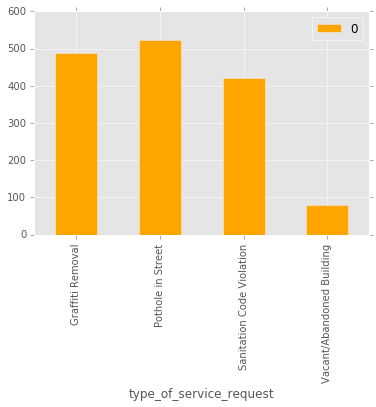

In [454]:
nlawndale = raw_311_sub[is_nlawndale]
nlawndale.groupby('type_of_service_request').size().to_frame().plot(kind='bar', color = 'orange')
plt.show()

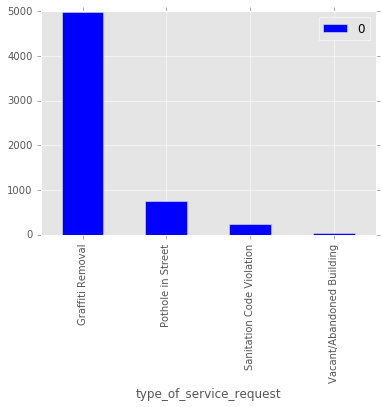

In [456]:
slawndale = raw_311_sub[is_slawndale]
slawndale.groupby('type_of_service_request').size().to_frame().plot(kind='bar', color = 'b')
plt.show()

<h3> Roughly 5500 requests for graffiti removal from North and South Lawndale. <h3>

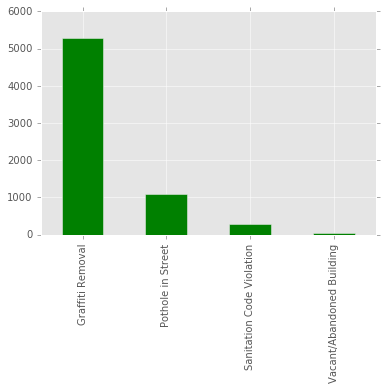

In [457]:
uptown = raw_311_sub[is_uptown]
uptown['type_of_service_request'].value_counts().plot(kind='bar', color = 'g')
plt.show()

<h3> Slightly fewer requests come from Uptown.  So it seems like there is a fairly equal probablity that the request comes from the North/South Lawndale area than Uptown, but it seems only by around 5500 -5300/10800 --> 200/18000 = .019 (or 1.9%) </h3>

<h3> Calls about graffiti from Englewood were 100 calls out of 600 total requests: ((100/600)*(600/1000))/(600/1000) = 16% likelihood the call is about graffiti and came from Englewood. </h3>

<h3>Calls about graffiti were 160 out of 400 total request: from Uptown (160/400)*(400/1000)/(400/1000) = 40% likelihood that the call is about graffiti and came from Uptown. 

It's about three times as likely that the call be from Uptown if it is about graffiti.</h3>
